# Spike transmission time
### Motivation
To chose an appropiate temporal window for the criticality analysis, we need to quantify the time it takes for a presynaptic neuron to excite a postsynaptic neuron.

### Approach
We do so by calculating the pair-wise cross-correlations between unidirectional connected neurons after x minutes of simulation.


### Requirements
Requires cch-analysis package [1]. Dockerfile attached.


https://github.com/tristanstoeber/cch-analysis

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from cch_analysis.cch import cch_significance
import pandas as pd

import h5py
import pickle
from brian2.units import *

In [2]:
def connections(a, b):
    g = f's{a}_{b}'
    return np.array(run_results[g][g])

## Parameters

In [63]:
# data
data_path = '../data/210118_000746/'
build="0002"

# correlogram
n_pairs = 100
bin_size=.001
limit=.02
hollow_kernel_fraction=0.6  # hollow kernel to convolve cch for signifcance test
hollow_kernel_width=10  # ms

sigma_threshold = 0.01

## Load files

In [4]:
hdf5 = h5py.File(data_path+'hdf5_data.hdf5', 'r')
run_results = hdf5['tr1']['results']['runs'][f'run_0000{build}']

with open(data_path+"gexc_spks.p", 'rb') as pfile:
    spks = pickle.load(pfile)
with open(data_path+'synee_a.p', 'rb') as pfile:
    synee_a = pickle.load(pfile)
    syn_active_ee = synee_a['syn_active'][-1]

#### Connection matrix

In [5]:
matrix = np.zeros(shape=(400, 400))
matrix[connections('EE', 'src'),\
       connections('EE', 'tar')] = syn_active_ee

#### Spikes

In [6]:
indxs = spks['t']>50*ksecond
spike_t = spks['t'][indxs]
spike_t.shape
# Convert to second
spike_t = spike_t/second

#### Neuron ids

In [7]:
ids = spks['i'][indxs]
ids.shape

(62783,)

## Analysis

#### Get available ids

In [8]:
i_unique = np.unique(ids)

#### Get synaptic pairs 

In [9]:
pre, post = np.where(matrix)
con = np.array([(pre_i, post_i) for pre_i, post_i in zip(pre, post)])

#### Choose a limited number of connections

In [10]:
i_sel = np.random.choice(np.arange(con.shape[0]), size=n_pairs, replace=False)  
con_sel = con[i_sel, :]

#### Calculate pairwise cross corelation
To obtain a significance value for each bin in the histogram, we compute the chance level of this count (see [2]).

[2] Stark, E., & Abeles, M. (2009). Unbiased estimation of precise temporal correlations between spike trains. Journal of neuroscience methods, 179(1), 90-100.

In [64]:
ls_res = []

for pre_i, post_i in con_sel:
    # retrieve spikes
    spks_pre = spike_t[ids==pre_i]
    spks_post = spike_t[ids==post_i]
    
    _, pfast, bins, cch, cch_smooth = cch_significance(
        spks_pre, spks_post,
        bin_size=bin_size,
        limit=limit,
        hollow_fraction=hollow_kernel_fraction,
        width=hollow_kernel_width
    )
    
    res_i = {
        'id_pre': pre_i,
        'id_post': post_i,
        'pfast': pfast,
        'bins': bins,
        'cch': cch,
        'cch_smooth': cch_smooth
    }
    
    ls_res.append(res_i)
    
df_res = pd.DataFrame(ls_res)

### Average timebin of positive peak.
We quantify the average time it takes for a spike to be transmitted across two coupled neurons.
To do so, we restrict our analysis to positive and significant counts, determine the timebin of the peak, and average across all pairs.

In [65]:
ls_delta_t = []

for i, row_i in df_res.iterrows():
    # extract values
    pfast = row_i['pfast']
    bins = row_i['bins'][:-1]
    cch = row_i['cch']
    
    # restrict values
    bool_bins_pos = bins > 0
    bool_sign = pfast <= sigma_threshold
    bool_bins = (bool_bins_pos & bool_sign)
    cch_sel = cch[bool_bins]
    bins_sel = bins[bool_bins]
    
    # get peak
    if len(cch_sel) > 0:
        pos_peak = np.argmax(cch_sel)
        delta_t = bins_sel[pos_peak]
    else:
        delta_t = np.nan
    ls_delta_t.append(delta_t)
    
df_res['delta_t_peak'] = ls_delta_t

In [66]:
delta_t_mean = np.nanmean(df_res['delta_t_peak'])
n_valid = df_res['delta_t_peak'].count()


Text(0.5, 0.5, 'Average $\\Delta_t$: $\\mu(\\Delta_t) = 0.0091$ seconds, across 18 of 100 pairs.')

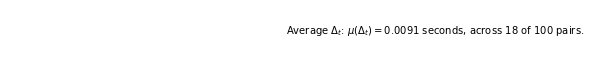

In [67]:
fig, ax = plt.subplots(1, figsize=(10, 1))
ax.axis('off')

ax.text(0.5, 0.5,r'Average $\Delta_t$: $\mu(\Delta_t) = '+str(np.round(delta_t_mean, 4))+'$ seconds, across '+str(n_valid)+' of ' + str(n_pairs) +' pairs.')


### Example plots

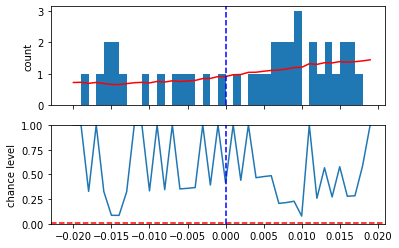

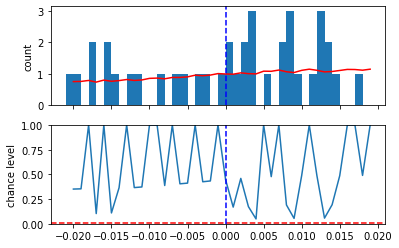

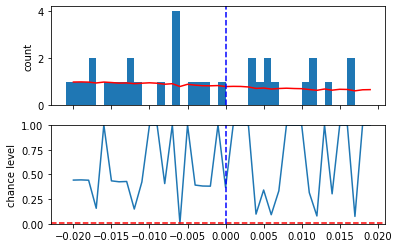

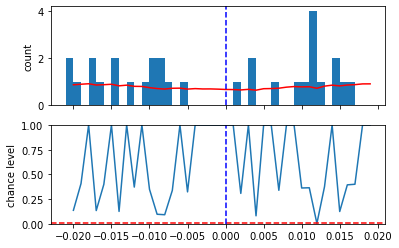

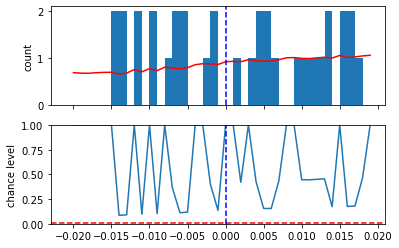

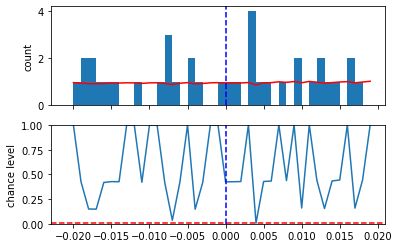

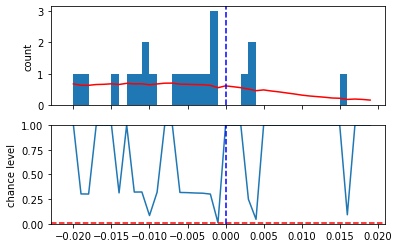

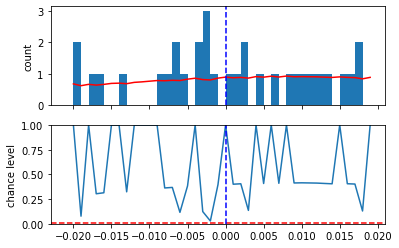

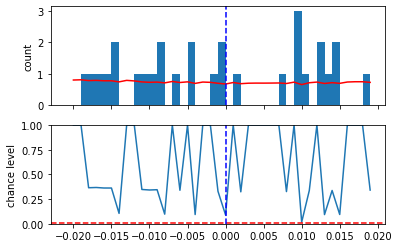

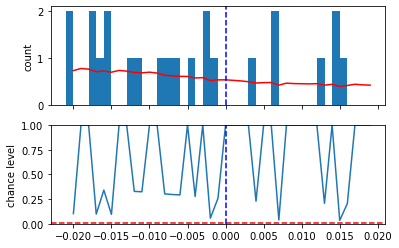

In [81]:
for i, row_i in df_res.iterrows():
    if i%10==1:
        pfast = row_i['pfast']
        bins = row_i['bins'][:-1]
        cch = row_i['cch']
        cch_smooth = row_i['cch_smooth']

        fig, ax = plt.subplots(2,1, sharex=True)
        ax[0].plot(bins, cch_smooth, 'r', label='smoothed cch')
        ax[0].bar(bins, cch, width=-bin_size, align='edge')
        ax[0].set_ylabel('count')
        ax[0].axvline(0., linestyle='--', color='b', label='threshold')

        #ax[0].legend(loc='upper left')
        
        ax[1].plot(bins, pfast, label='smoothed')
        ax[1].axhline(sigma_threshold, linestyle='--', color='r', label='threshold')
        ax[1].set_ylabel('chance level')
        ax[1].set_ylim(0, 1.)
        ax[1].axvline(0., linestyle='--', color='b', label='threshold')

        #ax[1].legend(loc='upper left')
